## imports

In [2]:
import cv2
import numpy as np

from tqdm import tqdm
from pathlib import Path

import os
from dotenv import load_dotenv
load_dotenv()

data_folder = Path( os.environ["DATA_FOLDER"] )
imgs_folder = data_folder / "images"

## Change all names to be 6 digits
for more convenient sorting

example: `0.txt` -> `000000.txt`

### renaming

In [15]:
eq_len_parent = 2
eq_len_file = 6

suf = ".jpg"

for file in tqdm(imgs_folder.glob(f"**/*{suf}"), total=1e6):
    parent = file.parent
    folder_num = parent.stem.zfill(eq_len_parent)  # 2
    file_num = file.stem.zfill(eq_len_file)        # 6

    new_parent = Path(f"{parent.parent}/{folder_num}")
    if not new_parent.exists():
        new_parent.mkdir()

    file.rename(new_parent / f"{file_num}{suf}")

100%|██████████| 1000000/1000000.0 [00:24<00:00, 40378.56it/s]


### remove empty folders

In [ ]:
for path in imgs_folder.iterdir():
    if path.is_dir() and (not list(path.iterdir())):
        print(path)
        path.rmdir()

### check

In [ ]:
print( list(imgs_folder.glob("**/*.jpg"))[:10] )
print( sorted(imgs_folder.glob("**/*.jpg"))[:10] )

In [ ]:
st = sorted(imgs_folder.glob("**/*.jpg"))

st[19999:20010]

## test

In [9]:
folder_num = 0

fodler_path = imgs_folder / str(folder_num).zfill(2)

folder_content = sorted(fodler_path.iterdir())

In [10]:
imgs_L = []
imgs_ab = []

for file in tqdm(folder_content):
    img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2LAB)
    # BGR -> Lab

    img = cv2.resize(img, (224, 224))
    # shape -> (224, 224)

    # img = img.astype(np.float32) / 255.0
    # # normalize all pixels to be in [0, 1]  (if not `astype`, dtype=float64)

    # img.shape = (224, 224, 3)
    imgs_L.append(img[:, :, 0])
    imgs_ab.append(img[:, :, 1:])




100%|██████████| 10000/10000 [00:30<00:00, 331.74it/s]


In [11]:
stack_L = np.stack(imgs_L)
stack_ab = np.stack(imgs_ab)

In [12]:
print(stack_L.dtype, stack_ab.dtype)
stack_L.shape, stack_ab.shape

uint8 uint8


((10000, 224, 224), (10000, 224, 224, 2))

In [12]:
np.save("ab0.npy", stack_ab)

## all files

In [ ]:
from io import StringIO
from PIL import Image

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(filename=".logs/corrupt_imgs.log", level=logging.INFO,
                    format="%(levelname)s:%(name)s:%(asctime)s:%(message)s",
                    datefmt="%I:%M:%S %p")

## for some reason ~5 images couldn't be opened properly,
##  furthermore there were 2 different errors that sound almost the same,
##  but have different checks
## as result, bottom part of image consists of only fray pixels,
##  but, as there are only 5 such images out of 1 mil, they were left as is
##  as some kind of noise (surely not laziness)

In [ ]:
for folder_num in tqdm(range(100), colour="#6ac856"):
    if (folder_num % 10 == 0):
        print(f"batch {folder_num // 10}")

    folder_num = str(folder_num).zfill(2)

    fodler_path = imgs_folder / folder_num
    folder_content = sorted(fodler_path.iterdir())

    imgs_L = []
    imgs_ab = []

    for file in folder_content:
        ### Premature end of JPEG file ##
        with open(file, 'rb') as f:
            check_chars = f.read()[-2:]

        if check_chars != b'\xff\xd9':
            log_str = (
                f"\n{file}\n"
                f"Not complete image"
            )
            print(log_str)
            logger.error(log_str + " (`Premature end of JPEG file`)")

        ### --- ##


        ### Corrupt JPEG data: premature end of data segment ##
        img = None
        with open(file, "rb") as img_bin:
            # buff = StringIO.StringIO
            # buff.write( img_bin.read() )
            # buff.seek(0)

            try:
                temp_img = np.array(Image.open(img_bin), dtype=np.uint8)
                img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR)
            except:
                logger.error("except block")
        
        if img is None:
            log_str = (
                f"\n{file}\n"
                f"temp_img: type = `{type(temp_img)}` | shape = {temp_img.shape}"
                f" |  min/max = {temp_img.min()}/{temp_img.max()}\n"
                f"img = `{img}`\n"
                f"Corrupt jpeg"
            )
            print(log_str)
            logger.error(log_str + " (`Corrupt JPEG data: premature end of data segment`)")
        
        ### --- ##


        img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2LAB)
        # BGR -> Lab

        img = cv2.resize(img, (224, 224))
        # shape -> (224, 224)

        # img = img.astype(np.float32) / 255.0
        # # normalize all pixels to be in [0, 1]  (if not `astype`, dtype=float64)

        # img.shape = (224, 224, 3)
        imgs_L.append(img[:, :, 0])
        imgs_ab.append(img[:, :, 1:])
    
    stack_L = np.stack(imgs_L)
    stack_ab = np.stack(imgs_ab)

    np.save(f"data/L/{folder_num}.npy", stack_L)
    np.save(f"data/ab/{folder_num}.npy", stack_ab)


## compare to ones from kaggle

#### from another one
[mirflickr25k-greylab-colorization-dataset](https://www.kaggle.com/datasets/pspino/mirflickr25k-greylab-colorization-dataset)

In [27]:
folder = data_folder / "kaggle_25k/other"

gray = np.load(folder / "gray_imgs.npy")
lab = np.load(folder / "lab_imgs.npy")

In [29]:
print( gray.dtype, lab[:,:,:,1:].dtype )
print( gray.shape, lab[:,:,:,1:].shape )

uint8 uint8
(23343, 224, 224, 1) (23343, 224, 224, 2)


In [30]:
print( gray.min(), lab[:,:,:,1:].min() )
print( gray.max(), lab[:,:,:,1:].max() )

0 0
255 255


In [34]:
(gray[:,:,:,0] == lab[:,:,:,0]).prod()

np.int64(0)

#### from prev one
[image-colorization](https://www.kaggle.com/datasets/shravankumar9892/image-colorization)

In [33]:
folder = data_folder / "kaggle_25k/"

gray = np.load(folder / "l/gray_scale.npy")
ab = np.load(folder / "ab/ab1.npy")

In [34]:
print( gray.dtype, ab.dtype )
print( gray.shape, ab.shape )

uint8 uint8
(25000, 224, 224) (10000, 224, 224, 2)


In [10]:
print( gray.min(), ab.min() )
print( gray.max(), ab.max() )

0 20
255 225


In [14]:
from torchvision.transforms import ToTensor

transform = ToTensor()

t  = transform(gray[0])
tt = transform(ab[0])
t.shape, tt.shape

(torch.Size([1, 224, 224]), torch.Size([2, 224, 224]))

In [15]:
print( t.min(), tt.min() )
print( t.max(), tt.max() )

tensor(0.0118) tensor(0.4510)
tensor(0.9961) tensor(0.7176)


---
# corrupted images showcase

In [ ]:
import matplotlib.pyplot as plt

In [16]:
q  = np.load(data_folder / "L/05.npy")
ab = np.load(data_folder /"ab/05.npy")

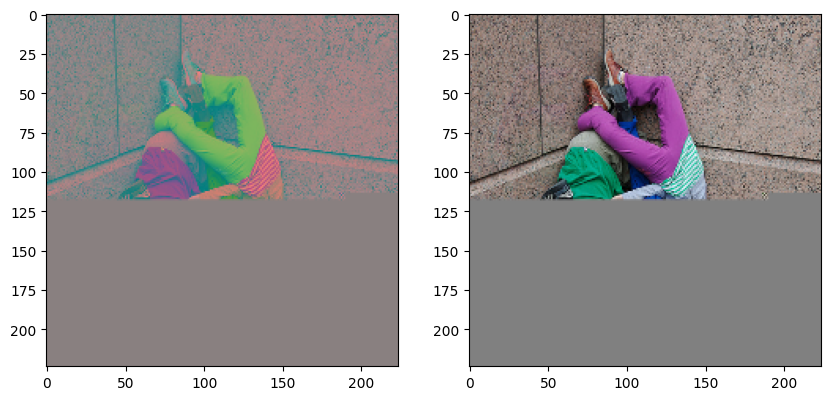

In [17]:
plt.figure(figsize=(10, 6))

img = np.zeros((224,224,3), dtype=np.uint8)
img[:,:,0] = q[9898]
img[:,:,1:] = ab[9898]

plt.subplot(1, 2, 1)
plt.imshow(img)

img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

plt.subplot(1, 2, 2)
plt.imshow(img)

plt.show()

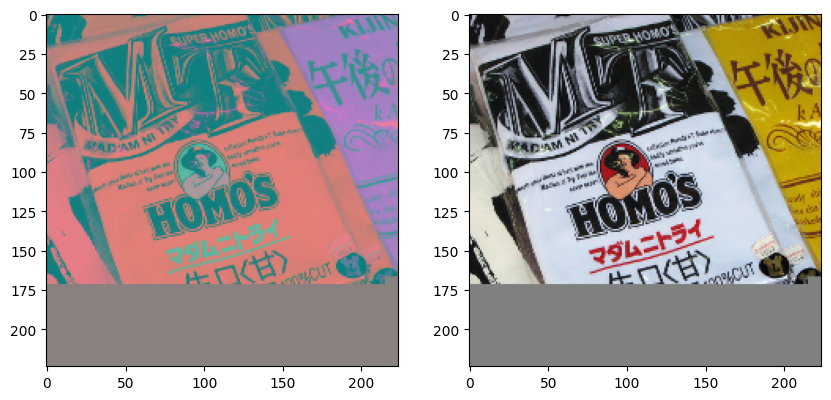

In [15]:
q  = np.load(data_folder / "L/68.npy")
ab = np.load(data_folder / "ab/68.npy")

plt.figure(figsize=(10, 6))

img = np.zeros((224,224,3), dtype=np.uint8)
img[:,:,0] = q[6806]
img[:,:,1:] = ab[6806]

plt.subplot(1, 2, 1)
plt.imshow(img)

img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

plt.subplot(1, 2, 2)
plt.imshow(img)

plt.show()